## Denoising Diffusion Probabilistic Models

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from n_framework import*
from activations_module import *

In [ ]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray'
logging.disable(logging.WARNING)

In [ ]:
clean_mem()

In [ ]:
x,y = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

- resizing our images to 32 by 32 from 28 by 28... to make it easier for model architecture

In [ ]:
@inplace
def transformi(b): b[x] = [ TF.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[x]]

In [ ]:
set_seed(42)
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs)
dt = dls.train
xb,yb = next(iter(dt))
xb.shape,yb[:10]

(torch.Size([128, 1, 32, 32]), tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5]))

* DDPM ( Denoising Diffusion Probabilistic Models ) is a u-net with modification like adding attention

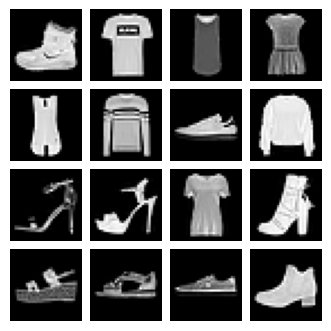

In [ ]:
show_images(xb[:16], imsize=0.8)

In [ ]:
betamin,betamax,n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin,betamax, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0) # alphabar is the cummulative of alpha
sigma = beta.sqrt()

[<matplotlib.lines.Line2D>]

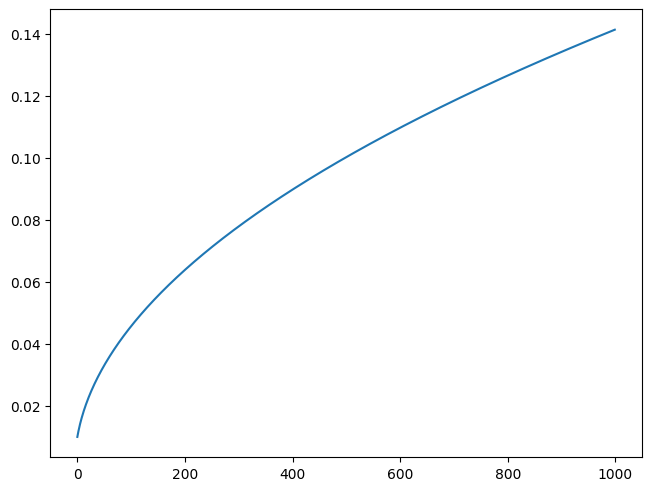

In [ ]:
plt.plot(sigma)

[<matplotlib.lines.Line2D>]

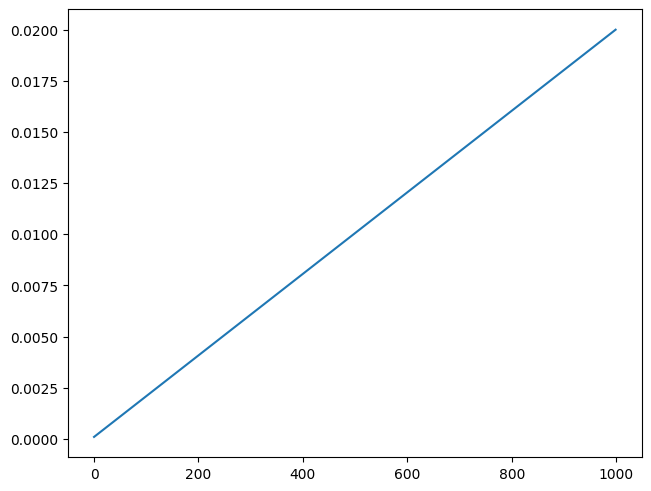

In [ ]:
plt.plot(beta)

[<matplotlib.lines.Line2D>]

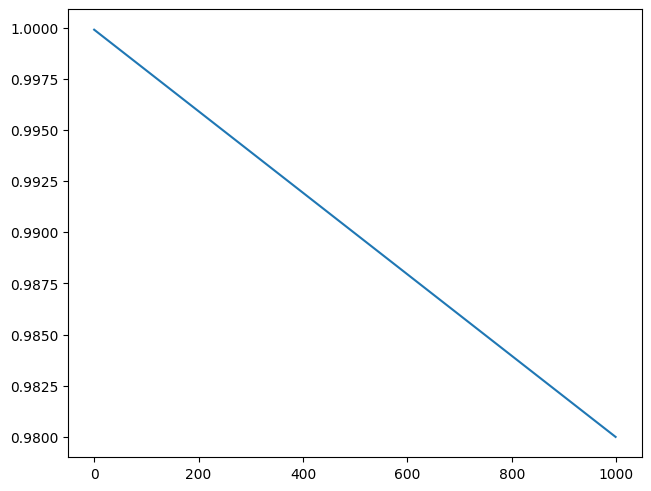

In [ ]:
plt.plot(alpha)

[<matplotlib.lines.Line2D>]

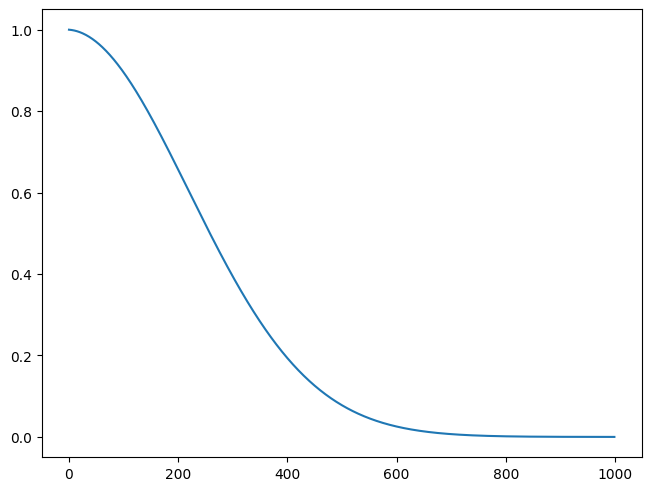

In [ ]:
plt.plot(alphabar)

In [ ]:
def noisify(x0,alphabar):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype= torch.long)
    epselon = torch.randn(x0.shape, device=device)
    alphabar_t = alphabar[t].reshape(-1,1,1,1).to(device)
    xt = alphabar_t.sqrt()*x0 + (1 - alphabar_t).sqrt()*epselon
    return (xt, t.to(device)),epselon

In [ ]:
(xt,t),epselon = noisify(xb[:25],alphabar)
t

tensor([ 84, 716, 290, 483, 126, 820, 933,  46,  27, 872, 925, 826, 969,  85, 991, 654, 335,  80, 325, 555, 259, 432, 974, 827, 293])

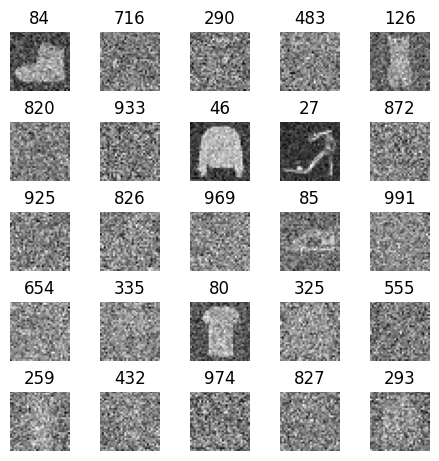

In [ ]:
titles = fc.map_ex(t, '{}') # extended map function from fastai, here it lets you add a string
show_images(xt, imsize=0.9,titles=titles)

installing diffusers will give so many errors untill hugging face recommendation of using conda installing.  
`conda install -c conda-forge diffusers`..... if you have mamba change conda for mamba(as mamba is faster version of conda)

In [ ]:
from diffusers import UNet2DModel

In [ ]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu())
    return preds

In [ ]:
class DDPMCB(callback):
    order = DeviceCB.order+1
    def __init__(self, n_steps, betamin, betamax): 
        fc.store_attr()
        self.beta = torch.linspace(self.betamin, self.betamax, self.n_steps)
        self.alpha = 1. - self.beta
        self.alphabar = torch.cumprod(self.alpha, dim=0)
        self.sigma = beta.sqrt()
        
    def before_batch(self,learn): learn.batch = noisify(learn.batch[0], self.alphabar)
    def sample(self, model,sz): return sample(model, sz, self.alpha, self.alphabar, self.sigma, self.n_steps) 

In [ ]:
# this comes handy even when not using miniai framework we are developing on top
# inheriting directly from the UNet, dont need predict and TrainCB callback
class UNet(UNet2DModel):
    def forward(self,x): return super().forward(*x).sample

In [ ]:
ddpm_cb = DDPMCB(n_steps=1000, betamin=0.0001, betamax= 0.02)

* uses group norm, split the channels up into certain number of groups (i.e 8)

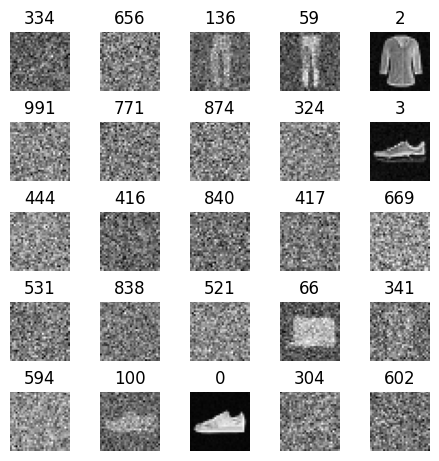

In [ ]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16,32,64,64), norm_num_groups=8) # dividing DDPM_tan channels by two

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs = [ddpm_cb, SingleBatchCB()])
(xt,t),epselon = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=0.9)

In [ ]:
lr = 5e-3
epochs=5
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr =lr, total_steps = tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchschedCB(sched)]

In [ ]:
model = UNet(in_channels=1, out_channels=1, block_out_channels= (16, 32, 64, 128), norm_num_groups=8)

In [ ]:
# initializing the ddpm,
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)
                
    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()
    model.conv_out.weight.data.zero_()

In [ ]:
init_ddpm(model)

In [ ]:
opt_func = partial(optim.AdamW, eps = 1e-5)
learn = TrainLearner(model , dls, nn.MSELoss(), cbs=cbs, lr=lr, opt_func=opt_func)

loss,epoch,train
0.144,0,train
0.026,0,eval
0.023,1,train
0.022,1,eval
0.021,2,train
0.020,2,eval
0.019,3,train
0.019,3,eval
0.018,4,train
0.018,4,eval


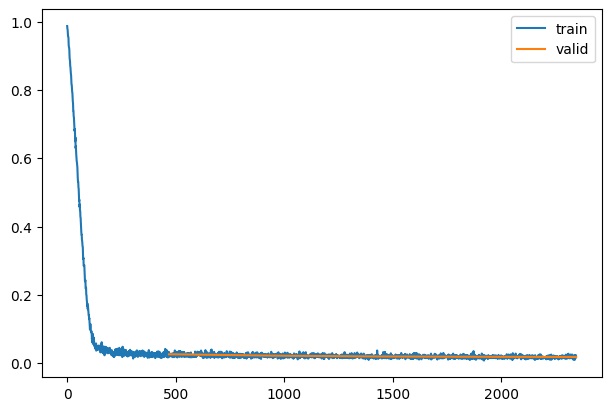

CPU times: user 52min 30s, sys: 2min 17s, total: 54min 47s
Wall time: 1h 4min 4s


In [ ]:
%time learn.fit(epochs)

In [ ]:
mdl_path= Path('models')

In [ ]:
torch.save(learn.model, mdl_path/'fashion_ddpm_jh.pkl')

##### Sampling

In [ ]:
samples = ddpm_cb.sample(learn.model,(16,1,32,32))

In [ ]:
show_images(samples[-1],figsize=(5,5))

### Mixed precision
* by default we use single precision (32 bit), GPU can fast using single precision but can go way faster by using half precision (16 bit),but we cant cast everthing to single precison, that wouldnt give us precise result when calculating gradients so mixing them when needed is mixed precision yeyyy
- https://forums.fast.ai/t/mixed-precision-training/20720 here is a more details on mixed precision from fastai form

In [ ]:
bs =512

In [ ]:
next(iter(DataLoader(tds['train'],batch_size=2)))

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]),
 'label': tensor([9, 0])}

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)[x],alphabar)
def dl_ddpm(ds): return DataLoader(ds,batch_size=bs, collate_fn=collate_ddpm)
#def dl_ddpm(ds): return DataLoader(ds,batch_size=bs, collate_fn=collate_ddpm, num_workers=4) # for non mac(mps)

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']),dl_ddpm(tds['test']))

In [ ]:
class MixedPrecisonCB(TrainCB):
    order = DeviceCB.order + 10
    
    def before_fit(self, learn): self.scaler = torch.cuda.amp.GradScaler()
    
    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype= torch.float16)
        self.autocast.__enter__()
    
    def after_loss(self, learn): self.autocast.__exit__(None, None, None)
        
    def backward(self, learn): self.scaler.scale(learn.loss).backward()
        
    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

In [ ]:
lr = 1e-2
epochs= 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr =lr, total_steps = tmax)
cbs =  [DeviceCB(),MixedPrecisonCB(), ProgressCB(plot=True), MetricsCB(), BatchschedCB(sched)]
model = UNet(in_channels=1, out_channels=1, block_out_channels= (16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr = lr, cbs=cbs, opt_func=opt_func)

In [ ]:
#run this with more GPU to run faster 
%time learn.fit(epochs)

## Accelerate

In [ ]:
from accelerate import Accelerator

In [ ]:
class AccelerateCB(TrainCB):
    order = DeviceCB.order+10
    def __init__(self, n_inp=1, mixed_precision= "fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learn):
        learn.model, learn.opt, learn.dls.train, learn.dls.valid = self.acc.prepare(
            learn.model, learn.opt, learn.dls.train, learn.dls.valid)
        
    def backward(self, learn): self.acc.backward(learn.loss)

In [ ]:
def noisify(x0,alphabar):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype= torch.long)
    epselon = torch.randn(x0.shape, device=device)
    alphabar_t = alphabar[t].reshape(-1,1,1,1).to(device)
    xt = alphabar_t.sqrt()*x0 + (1 - alphabar_t).sqrt()*epselon
    return xt, t.to(device),epselon

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']),dl_ddpm(tds['test']))

In [ ]:
class DDPMCB2(callback):
    def after_predict(self, learn): learn.preds = learn.preds.sample

In [ ]:
model = UNet(in_channels=1, out_channels=1, block_out_channels= (16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs =  [DDPMCB2,DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchschedCB(sched), AccelerateCB(n_inp=2)]
learn = Learner(model, dls, nn.MSELoss(), lr = lr, cbs=cbs, opt_func=opt_func)

In [ ]:
%time learn.fit(epochs)

## sneaky Trick
- to speed up while using like kaggle instead of waiting for ur cpu and the Gpu is waiting idle it spits out twice batchs

In [ ]:
class MultDL:
    def __init__(self, dl, mult=2): self.dl,self.mult = dl,mult
    def __len__(self): return len(self.dl)*self.mult
    def __iter__(self):
        for o in self.dl:
            for i in range(self.mult): yield o

In [ ]:

dls.train = MultDL(dls.train)